In [362]:
import pandas as pd
import os
import re
import sys
import matplotlib.pyplot as plt
import numpy as np

In [363]:
sys.path.append('../statistics')
from mylib import mylibrary as ml
current_dir = !pwd
current_dir = current_dir[0]
current_dir

'/var/tmp/vcloud-q3b/statistics_final'

In [364]:
versions = {"orig" : "/original", "none":"/approx_of_abstr_of/","approx" : "/approx_on_abstr_of/", "abstr":"/approx_of_abstr_on/", "both":"/approx_on_abstr_on/" }

In [425]:
def merge_benchmark_families(adict):
    benchmarks = ['2017-Preiner-UltimateAutomizer',
 '2017-Preiner-keymaera',
 '2017-Preiner-psyco',
 '2017-Preiner-scholl-smt08',
 '2017-Preiner-tptp',
 '20170501-Heizmann-UltimateAutomizer',
 '2018-Preiner-cav18',
 '20190429-UltimateAutomizerSvcomp2019',
 '2020-Preiner-fmcad20',
 '20210301-Alive2',
 '20210301-Alive2-partial-undef',
 '20230321-UltimateAutomizerSvcomp2023',
 'llvm13-smtlib',
 'wintersteiger']
    return pd.concat([adict[x] for x in benchmarks], ignore_index=True)

In [426]:
frames = {}

for v in versions:
    frames[v] = merge_benchmark_families(ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[v]))))

# Get set of benchmarks that fail (not in my parts of code)

In [428]:
def get_failing_benchmarks(df):
    failig_benchmarks = df[~df['result'].isin(['true', 'false', 'TIMEOUT'])]
    return set(failig_benchmarks['benchmarkfile'])

In [429]:
def get_fails(frames):
    fail = set()
    for df in frames.values():
        fail = fail.union(get_failing_benchmarks(df))
    return fail

In [447]:
fails = get_fails(frames)
len(fails)


33

In [431]:
def get_num_of_benchmarks(adict):
    counter = 0
    for df in adict.values():
        counter += df.shape[0]
    return counter

In [434]:
def remove_fails_from_df(df, fails):
    return df[~df['benchmarkfile'].isin(fails)]

In [435]:
def remove_fails_form_dict(benchm_dict, fails):
    for benchname in benchm_dict:
        benchm_dict[benchname] = remove_fails_from_df(benchm_dict[benchname], fails)
    return benchm_dict

In [436]:
get_num_of_benchmarks(remove_fails_form_dict(benchm_dict, fails))

6125

In [437]:
def get_df(path):
    csv = ml.get_csv(path)
    df = ml.dict_to_df(ml.get_data(csv))
    fails = get_fails(frames)
    df = remove_fails_form_dict(df, fails)
    sumdata = ml.sum_data(df)
    timedata = ml.time_data(df)
    sumdata = sumdata.reindex(sorted(sumdata.columns), axis=1)
    timedata = timedata.reindex(sorted(timedata.columns), axis=1)
    #sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T
    return sumdata, timedata
    

In [438]:
sums = []
for v in versions:
    sumdata = get_df(current_dir+versions[v])[0]
    sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": v})
    sums.append(sumdata)

# Join

In [439]:
merged = orig_sum_solved
for df in sums:
    merged = pd.merge(merged, df, left_index=True, right_index=True, suffixes=('', '_2'))
    
cols_to_drop = [col for col in merged.columns if col.endswith('_2')]

# Drop these columns
merged.drop(cols_to_drop, axis=1, inplace=True)

In [440]:
total_row = merged.sum()
total_row

total     6125
orig      5834
none      5832
approx    5859
abstr     5830
both      5857
dtype: int64

In [460]:
merged.loc['Total'] = total_row
ml.write_to_file("/home/xschwar3/dp/statistics/comparison.tex", merged.to_latex())
merged

,total,orig,none,approx,abstr,both
2017-Preiner-UltimateAutomizer,153,153,153,153,153,153
2017-Preiner-keymaera,4035,4008,4010,4010,4009,4010
2017-Preiner-psyco,194,151,152,152,152,152
2017-Preiner-scholl-smt08,356,287,287,287,286,286
2017-Preiner-tptp,73,73,73,73,73,73
20170501-Heizmann-UltimateAutomizer,127,110,109,109,109,109
2018-Preiner-cav18,600,563,563,563,563,563
20190429-UltimateAutomizerSvcomp2019,96,86,86,86,86,86
2020-Preiner-fmcad20,165,128,127,128,129,127
20210301-Alive2,1,0,0,0,0,0


# CPU time comparison

In [473]:
def create_time_comparison(version1, version2, current_dir):
    
    adict1 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir + versions[version1])))
    adict2 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[version2])))
    
    fails = get_fails(frames)
    adict1 = remove_fails_form_dict(adict1, fails)
    adict2 = remove_fails_form_dict(adict2, fails)
    df1 = merge_benchmark_families(adict1)
    df2 = merge_benchmark_families(adict2)
    df2 = df2[df2['result'].isin(['true', 'false', 'TIMEOUT'])]
    df1 = df1[df1['result'].isin(['true', 'false', 'TIMEOUT'])]
    intersection_df = pd.merge(df1, df2, on='benchmarkfile', how='inner')
    return intersection_df
    
    


In [474]:
def show_plot(df, column, filename):
    # Data
    x = df[column+"_x"]
    y = df[column+"_y"]
    
    
    print(len(x))
    print(len(y))
    ref_line = [i for i in range(0, 1000)]  # Reference line (y=x)

    # Scatter plot
    plt.scatter(x, y, label='Data points')

    
    
    
    if column == "cputime":
        ref_line = [i for i in range(0, 300)]  # Reference line (y=x)
        # Add red vertical and horizontal lines at x=300 and y=300
        plt.axvline(x=300,color='red', linestyle='--',linewidth=0.5)
        plt.axhline(y=300, color='red', linestyle='--', linewidth=0.5)

        # Change tick labels on x-axis and y-axis at point 300 to "timelimit"
        plt.xticks([300], ['timelimit'])
        plt.yticks([300], ['timelimit'])
        
    
    
    plt.xlabel('original Q3B')
    plt.ylabel('Q3B -- approx on, abstr of')
    plt.title('CPU time comparison')
    
    
    # Set scale to logarithmic
    plt.xscale('log')
    plt.yscale('log')
    # Reference line
    plt.plot(ref_line, ref_line, label='Reference line', color='red', linestyle='-')

    plt.grid(True)
    plt.savefig(filename+".pdf", format="pdf", bbox_inches="tight")
    #plt.show()
    return plt

6125
6125


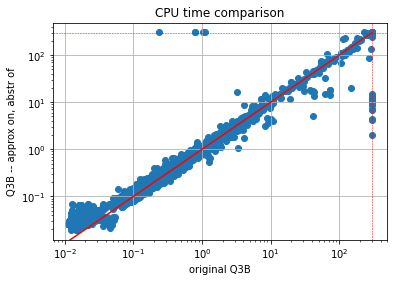

In [475]:
plt = show_plot(create_time_comparison('orig', 'approx', current_dir), 'cputime', 'orig-approx')

# Cross comparison

In [476]:
def uniquely_solved(df1, df2):
    solved1 = df1[df1['result'].isin(['true', 'false'])] # ty co vyresil levej
    unsolved2 = df2[~df2['result'].isin(['true', 'false'])]
    intersection_df = pd.merge(solved1, unsolved2, on='benchmarkfile', how='inner')
    return intersection_df.shape[0]

In [477]:
data = {}
for s1 in versions:
    data[s1] = []
    for s2 in versions:
        adict1 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir + versions[s1])))
        adict2 = ml.dict_to_df(ml.get_data( ml.get_csv(current_dir+versions[s2])))
        fails = get_fails(frames)
        adict1 = remove_fails_form_dict(adict1, fails)
        adict2 = remove_fails_form_dict(adict2, fails)
        df1 = merge_benchmark_families(adict1)
        df2 = merge_benchmark_families(adict2)
        data[s1].append(uniquely_solved(df1, df2))


In [481]:
labels = list(versions.keys())
df = pd.DataFrame(data, index=labels,dtype=object)
np.fill_diagonal(df.values, "x")
cross_comparison = df.T

In [482]:
ml.write_to_file("/home/xschwar3/dp/statistics/cross_comparison.tex", cross_comparison.to_latex())
